In [1]:
!python asr-1.py record myvoice.wav 30

Recording ...
Finished.


In [2]:
!python asr-1.py play myvoice.wav 30

In [3]:
!python asr-1.py transcribe myvoice.wav

In [4]:
!python asr-1.py evaluate myvoice_transcription.txt ground-truth.txt

In [1]:
import numpy as np
import json
import nltk
from nltk.tokenize import sent_tokenize
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

In [2]:
# Load pre-trained spelling correction model and tokenizer
spelling_correction = 'oliverguhr/spelling-correction-english-base'
spelling_model = AutoModelForSeq2SeqLM.from_pretrained(spelling_correction)
spelling_tokenizer = AutoTokenizer.from_pretrained(spelling_correction)

In [3]:
# Load pre-trained grammar correction model and tokenizer
grammar_correction = 'vennify/t5-base-grammar-correction'
grammar_model = AutoModelForSeq2SeqLM.from_pretrained(grammar_correction)
grammar_tokenizer = AutoTokenizer.from_pretrained(grammar_correction)

In [4]:
# Function to correct spelling
def correct_spelling(input_text):
    sentences = sent_tokenize(input_text)
    corrected_sentences = []
    for sentence in sentences:
        tokens = spelling_tokenizer(sentence, return_tensors="pt", truncation=True, max_length=spelling_tokenizer.model_max_length)
        outputs = spelling_model.generate(**tokens, max_length=spelling_tokenizer.model_max_length)
        corrected_sentence = spelling_tokenizer.decode(outputs[0], skip_special_tokens=True)
        corrected_sentences.append(corrected_sentence)
    return ' '.join(corrected_sentences)

# Function to correct grammar
def correct_grammar(input_text):
    tokens = grammar_tokenizer(input_text, return_tensors="pt", truncation=True, max_length=grammar_tokenizer.model_max_length)
    outputs = grammar_model.generate(**tokens, max_length=grammar_tokenizer.model_max_length)
    return grammar_tokenizer.decode(outputs[0], skip_special_tokens=True)

# Function to correct both spelling and grammar
def correct_spelling_and_grammar(input_text):
    spelling_corrected = correct_spelling(input_text)
    return correct_grammar(spelling_corrected)

In [5]:
# Read input text from file
with open('myvoice_transcription.txt', 'r', encoding='utf-8') as file:
    input_text = file.read().strip()

# Apply corrections
spelling_corrected_text = correct_spelling(input_text)
grammar_corrected_text = correct_grammar(input_text)
combined_corrected_text = correct_spelling_and_grammar(input_text)

In [6]:
print("Original text:\n", input_text)
print("\nSpelling corrected text:\n", spelling_corrected_text)
print("\nGrammar corrected text:\n", grammar_corrected_text)
print("\nCombined spelling and grammar corrected text:\n", combined_corrected_text)

Original text:
 ebarkmentof conservation our foocas is unsustainable leaving a critical aspect of protecting al were planet sustainable leaving involves reducing waste conserving natural resources and making choices that benefit the environment simple actions like recycling using energy efficient appliances and reducing water usage can have a significant impact remember every small step we take towards eqofrontiness contribute to larger global afford in preserving

Spelling corrected text:
 Barkment of conservation our foocas is unsustainable, leaving a critical aspect of protecting all where planet sustainable leaving involves reducing waste, conserving natural resources and making choices that benefit the environment simple actions like recycling using energy efficient appliances and reducing water usage can have a significant impact remember every small step we take towards profitability contribute to larger global afford in preserving.

Grammar corrected text:
 Our environment is u

In [7]:
# Specify the filename
output_filename = "../Data/myvoice_transcription_corrected.txt"

# Save the combined corrected text to a file
with open(output_filename, 'w', encoding='utf-8') as file:
    file.write(combined_corrected_text)

print(f"Combined corrected text saved to {output_filename}")

Combined corrected text saved to ../Data/myvoice_transcription_corrected.txt


In [8]:
def calculate_wer(reference, hypothesis):
    r = reference.split()
    h = hypothesis.split()
    # Building the matrix
    d = np.zeros((len(r)+1)*(len(h)+1), dtype=np.uint8)
    d = d.reshape((len(r)+1, len(h)+1))
    for i in range(len(r)+1):
        for j in range(len(h)+1):
            if i == 0: 
                d[0][j] = j
            elif j == 0: 
                d[i][0] = i
    # Calculation
    for i in range(1, len(r)+1):
        for j in range(1, len(h)+1):
            if r[i-1] == h[j-1]:
                d[i][j] = d[i-1][j-1]
            else:
                substitute = d[i-1][j-1] + 1
                insert = d[i][j-1] + 1
                delete = d[i-1][j] + 1
                d[i][j] = min(substitute, insert, delete)
    return d[len(r)][len(h)] / float(len(r))


In [9]:
def calculate_cer(reference, hypothesis):
    r = reference
    h = hypothesis
    # Building the matrix
    d = np.zeros((len(r)+1)*(len(h)+1), dtype=np.uint8)
    d = d.reshape((len(r)+1, len(h)+1))
    for i in range(len(r)+1):
        for j in range(len(h)+1):
            if i == 0:
                d[0][j] = j
            elif j == 0:
                d[i][0] = i
    # Calculation
    for i in range(1, len(r)+1):
        for j in range(1, len(h)+1):
            if r[i-1] == h[j-1]:
                d[i][j] = d[i-1][j-1]
            else:
                substitute = d[i-1][j-1] + 1
                insert = d[i][j-1] + 1
                delete = d[i-1][j] + 1
                d[i][j] = min(substitute, insert, delete)
    return d[len(r)][len(h)] / float(len(r))


In [12]:
# Read ground truth text from file
with open('ground_truth.txt', 'r', encoding='utf-8') as file:
    ground_truth_text = file.read().strip()

# Calculate WER and CER for spelling-corrected text
spelling_wer = calculate_wer(ground_truth_text, spelling_corrected_text)
spelling_cer = calculate_cer(ground_truth_text, spelling_corrected_text)

# Calculate WER and CER for grammar-corrected text
grammar_wer = calculate_wer(ground_truth_text, grammar_corrected_text)
grammar_cer = calculate_cer(ground_truth_text, grammar_corrected_text)

# Calculate WER and CER for combined corrected text
combined_wer = calculate_wer(ground_truth_text, combined_corrected_text)
combined_cer = calculate_cer(ground_truth_text, combined_corrected_text)

# Read WER and CER from results.json
with open('../Data/results.json', 'r', encoding='utf-8') as file:
    results_data = json.load(file)

original_wer = results_data.get("word_error_rate", "Not available")
original_cer = results_data.get("character_error_rate", "Not available")

# Print WER and CER for each type of corrected text
print("Original Text - Word Error Rate:", original_wer)
print("Original Text - Character Error Rate:", original_cer)
print("Spelling Corrected Text - Word Error Rate:", spelling_wer)
print("Spelling Corrected Text - Character Error Rate:", spelling_cer)
print("Grammar Corrected Text - Word Error Rate:", grammar_wer)
print("Grammar Corrected Text - Character Error Rate:", grammar_cer)
print("Combined Corrected Text - Word Error Rate:", combined_wer)
print("Combined Corrected Text - Character Error Rate:", combined_cer)


Original Text - Word Error Rate: 0.5087719298245614
Original Text - Character Error Rate: 0.19390581717451524
Spelling Corrected Text - Word Error Rate: 0.453125
Spelling Corrected Text - Character Error Rate: 0.15176715176715178
Grammar Corrected Text - Word Error Rate: 0.375
Grammar Corrected Text - Character Error Rate: 0.14137214137214138
Combined Corrected Text - Word Error Rate: 0.421875
Combined Corrected Text - Character Error Rate: 0.16216216216216217


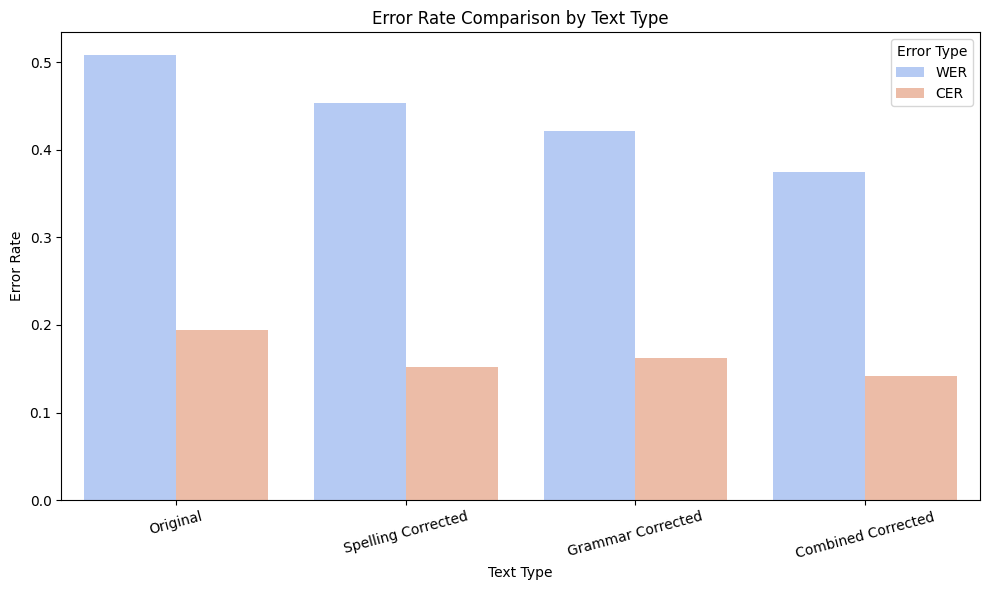

In [13]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Data for visualization
data = {
    "Text Type": ["Original", "Spelling Corrected", "Grammar Corrected", "Combined Corrected"] * 2,
    "Error Rate": [
        0.5087719298245614, 0.453125, 0.421875, 0.375,
        0.19390581717451524, 0.15176715176715178, 0.16216216216216217, 0.14137214137214138
    ],
    "Error Type": ["WER"]*4 + ["CER"]*4
}

df = pd.DataFrame(data)

# Plotting with Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x="Text Type", y="Error Rate", hue="Error Type", data=df, palette="coolwarm")
plt.title("Error Rate Comparison by Text Type")
plt.ylabel("Error Rate")
plt.xlabel("Text Type")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()
